## The Waterfall Plots for SHAP Values of Any Models

* Please read [Explain your model with the SHAP values](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d) and [The SHAP with More Elegant Charts](https://dataman-ai.medium.com/the-shap-with-more-elegant-charts-bc3e73fa1c0c)

### Table of Contents
* [Section 1: Matplotlib](#section1)
    * [Section 1.1: Random forest](#section11)
    * [Section 1.2: XGB](sSection12)
* [Section 2: Plotly](#section2)
    * [Section 2.1: Random forest](#section21)
    * [Section 2.2: XGB](#section22)

In [21]:
from sklearn.model_selection import train_test_split
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

df = pd.read_csv('/winequality-red.csv')

features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Y = np.where(df['quality']>6,1,0)
X =  df[features]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1234)
df['quality'] = df['quality'].astype(int)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


<AxesSubplot:>

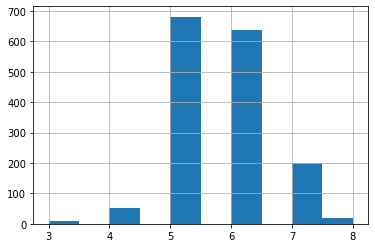

In [22]:
df['quality'].hist()

## (1) Matplotlib <a class="anchor" id="section1"></a>

### (1.1) Random forest <a class="anchor" id="section11"></a>



In [23]:
# Build the model with the random forest regression algorithm:
rf_model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
rf_model.fit(X_train, Y_train).score(X_train,Y_train)

0.6940550067343673

In [24]:
rf_model_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_model_explainer.shap_values(X_test)
base_value = Y_train.mean()
Y_pred_prob = rf_model.predict(X_test)
Y_pred = np.where(Y_pred_prob>base_value,1,0)

### (1.2) Waterfall plot  <a class="anchor" id="section12"></a>

In [25]:
def obs_to_explain(data,shap_values, base_value,green_color ='#29EA38' , red_color = '#FB3C62',n=8):
    '''
      - data: the observation. It is a Pandas series. The index contains the variable names 
      - shap_values: the shap_values for the above observation 
      - base_value: the base_value, which is the expected value or the mean of the target value of the training set
      - green_color: the color for the up bar
      - red_color: the color for the down bar
      - for_plot: a sorted data frame by the absolute value of shape in descending order
      - n: show the top n (default) variables. The rest variables are summed up into "others"
    '''
    for_plot = pd.DataFrame({'data':np.round(data,2),
                             'shap':shap_values,
                             'shap_abs': np.abs(shap_values),
                             'label': data.index
                            })
    for_plot = for_plot.sort_values(by='shap_abs',ascending=False)

    # Split the variables into n and the rest. Only show the top n
    for_plot1 = for_plot.iloc[0:n,:]
    for_plot2 = for_plot.iloc[n:,:]

    # Sum up the rest as 'others'
    rest = pd.DataFrame({'data': '','shap':for_plot2['shap'].sum(), 'label': 'Others'},index=['others'])
    for_plot = for_plot1.append(rest)
    
    # Sum up the rest into 'others'
    base = pd.DataFrame({'data': np.round(base_value,2),'shap':base_value, 'label': 'Base value'},index=['base_value'])
    for_plot = base.append(for_plot)

    for_plot['blank'] = for_plot['shap'].cumsum().shift(1).fillna(0) # +  base_value
    for_plot['label'] = + for_plot['label'] + " =" + for_plot['data'].map(str) 
    for_plot['color'] = np.where(for_plot['shap']>0,green_color,red_color)
    for_plot = for_plot.drop(['data','shap_abs'],axis=1)
    return(for_plot )  


In [26]:
obs = 10
rf_obs_to_explain = obs_to_explain(data = X_test.iloc[obs,:],
                         base_value = base_value,
                         shap_values = rf_shap_values[obs])
rf_obs_to_explain

,shap,label,blank,color
base_value,0.137608,Base value =0.14,0.000000,#29EA38
alcohol,-0.055662,alcohol =9.5,0.137608,#FB3C62
total sulfur dioxide,-0.036046,total sulfur dioxide =81.0,0.081945,#FB3C62
sulphates,-0.022881,sulphates =0.54,0.045899,#FB3C62
volatile acidity,-0.019963,volatile acidity =0.72,0.023018,#FB3C62
free sulfur dioxide,0.014723,free sulfur dioxide =13.0,0.003055,#29EA38
citric acid,-0.004883,citric acid =0.22,0.017778,#FB3C62
density,-0.003330,density =1.0,0.012895,#FB3C62
residual sugar,-0.003327,residual sugar =2.3,0.009564,#FB3C62
others,-0.000794,Others =,0.006237,#FB3C62


In [27]:
def waterfall_plot(
    for_plot,
    Title="The Prediction " ,
    x_lab="",
    y_lab="The predicted value",
    formatting = "{:,.2f}",
    rotation_value = 90,
    figsize = (7,5),
    green_color ='#29EA38' , 
    red_color = '#FB3C62'
    ):
    '''
      - x_lab, y_lab: the x label and y label
      - formatting: show the value of each bar 
      
    '''
 
    fig, ax = plt.subplots(figsize=figsize)

    # Plot the waterfall    
    plt.bar(range(0,len(for_plot.index)), for_plot['shap'], width=0.6,
          bottom=for_plot['blank'],     color=for_plot['color'])     

    #axis labels
    plt.xlabel("\n" + x_lab)
    plt.ylabel(y_lab + "\n")

    #Get the y-axis position for the labels
    y_height = for_plot.shap.cumsum().shift(1).fillna(0) #+ base_value

    plot_max = for_plot['shap'].max()
    plot_min = for_plot['shap'].min()
    pos_offset = plot_max / 40
    plot_offset = plot_max / 15 
    total = for_plot.sum().shap 

    # label the shap values
    loop = 0
    for index, row in for_plot.iterrows():
        # For the last item in the list, we don't want to double count
        if row['shap'] == total:
                y = y_height[loop]
        else:
                y = y_height[loop] + row['shap']
        
        if row['shap'] > 0:
                y += (pos_offset*2)
                plt.annotate(formatting.format(row['shap']),(loop,y),ha="center", color = green_color, fontsize=10)
        else:
                y -= (pos_offset*4)
                plt.annotate(formatting.format(row['shap']),(loop,y),ha="center", color = red_color, fontsize=10)
        loop+=1

    # Range of the ylim
    plt.ylim(plot_min-round(3.6*plot_offset, 7) ,plot_max+round(3.6*plot_offset, 7))

    #Rotate the labels
    plt.xticks(range(0,len(for_plot)), for_plot['label'], rotation=rotation_value)

    #add the base value line and title
    #plt.axhline(base_value, color='black', linewidth = 0.6, linestyle="dashed")
    plt.title(Title)

    import matplotlib.patches as mpatches
    red_patch = mpatches.Patch(color=red_color, label='Down')
    green_patch = mpatches.Patch(color=green_color, label='Up')
    plt.legend(handles=[red_patch,green_patch],bbox_to_anchor=[1, 1], loc='upper left')

    #plt.tight_layout()
    return(fig)

The predicted value is: 0.005
The expected value is: 0.138
The predicted group is: 0
The Actual value is: 0


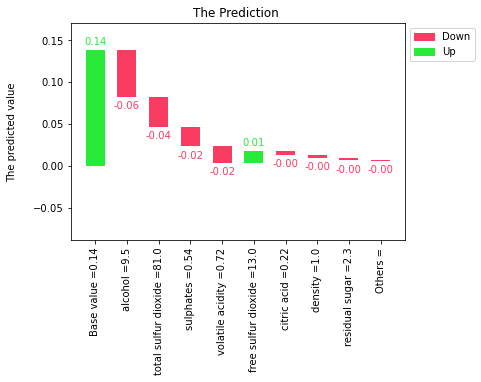

In [28]:
obs =10
print("The predicted value is: " +  str(np.round(Y_pred_prob[obs],3)))
print("The expected value is: " +  str(np.round(base_value,3)))
print("The predicted group is: " +  str(np.round(Y_pred[obs],0)))
print("The Actual value is: " +  str(np.round(Y_test[obs],3)))

f = waterfall_plot(rf_obs_to_explain,    figsize = (6,4))

### (1.2) XGB <a class="anchor" id="section12"></a>

In [29]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, Y_train).score(X_train,Y_train)

0.999638222863754

In [30]:
xgb_model_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_model_explainer.shap_values(X_test)
base_value = Y_train.mean()
Y_pred_prob = xgb_model.predict(X_test)
Y_pred = np.where(Y_pred_prob>base_value,1,0)

In [31]:
obs = 10
xgb_obs_to_explain = obs_to_explain(data = X_test.iloc[obs,:],
                         base_value = base_value,
                         shap_values = xgb_shap_values[obs])
xgb_obs_to_explain

,shap,label,blank,color
base_value,0.137608,Base value =0.14,0.000000,#29EA38
alcohol,-0.037175,alcohol =9.5,0.137608,#FB3C62
volatile acidity,-0.035487,volatile acidity =0.72,0.100433,#FB3C62
total sulfur dioxide,-0.031421,total sulfur dioxide =81.0,0.064945,#FB3C62
sulphates,-0.025581,sulphates =0.54,0.033525,#FB3C62
free sulfur dioxide,0.019973,free sulfur dioxide =13.0,0.007943,#29EA38
chlorides,-0.013829,chlorides =0.08,0.027917,#FB3C62
density,-0.007089,density =1.0,0.014087,#FB3C62
residual sugar,-0.006972,residual sugar =2.3,0.006998,#FB3C62
others,0.000606,Others =,0.000026,#29EA38


The predicted value is: 0.001
The expected value is: 0.138
The predicted group is: 0
The Actual value is: 0


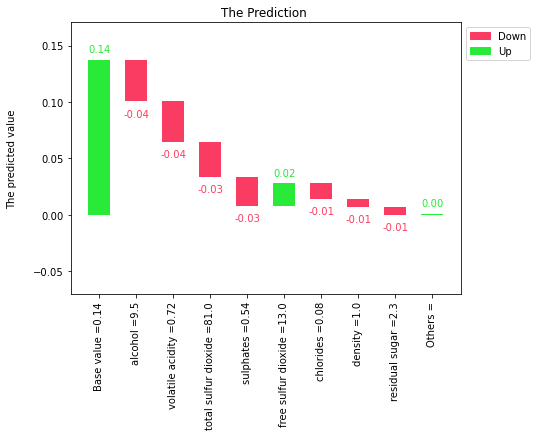

In [32]:
# XGB
print("The predicted value is: " +  str(np.round(Y_pred_prob[obs],3)))
print("The expected value is: " +  str(np.round(base_value,3)))
print("The predicted group is: " +  str(np.round(Y_pred[obs],0)))
print("The Actual value is: " +  str(np.round(Y_test[obs],3)))

f = waterfall_plot(xgb_obs_to_explain)

## (2) Plotly <a class="anchor" id="section2"></a>

In [35]:
def waterfall_plotly(xs,texts,ys,y_pred):
    import plotly.graph_objects as go
    import numpy as np
    
    
    ms = list(np.repeat('relative',len(ys)))

    fig = go.Figure(go.Waterfall(
        name = "20", orientation = "v",
        measure = ms,
        x = xs,
        textposition = "outside",
        text = texts,
        y = ys,
        connector = {"line":{"color":"rgb(63, 63, 63)"} },
       ) )


    layout = go.Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )

    fig.update_layout(
        template="plotly_white",
        title ="The prediction of this observation is: " + str(np.round(y_pred,2)),
        margin=dict(l=120, r=120, t=60, b=60),
        yaxis=dict(
            title_text="The predicted value" 
        ),
        xaxis =dict(
            tickangle = -90,
            title_text = "Variables")
    )
    fig.write_html('/first.html', auto_open=True)

### (2.1) Random forest <a class="anchor" id="section21"></a>

In [38]:
obs = 10
rf_obs_to_explain = obs_to_explain(data = X_test.iloc[obs,:],
                         base_value = base_value,
                         shap_values = rf_shap_values[obs])

xs = list(rf_obs_to_explain['label'].values)
texts = rf_obs_to_explain['shap'].round(2)
ys = rf_obs_to_explain['shap'].round(2)
waterfall_plotly(xs,texts,ys,Y_pred[obs])

### (2.2) XGB <a class="anchor" id="section22"></a>

In [37]:
obs = 10
xgb_obs_to_explain = obs_to_explain(data = X_test.iloc[obs,:],
                         base_value = base_value,
                         shap_values = xgb_shap_values[obs])

xs = list(xgb_obs_to_explain['label'].values)
texts = xgb_obs_to_explain['shap'].round(2)
ys = xgb_obs_to_explain['shap'].round(2)
waterfall_plotly(xs,texts,ys,Y_pred[obs])